# Text2bank

- na zaciatku: velka matica s klucovymi slovami a mnohymi triedami od Pavla Svobody
- na zaklade toho NB s levenshtein
- ensemble: myslel som, ze vytazene entity budu tiez prispievat ku klasifikacii
    - diakritika
- nerobil som crossvalidaciu, iba gridsearch, kedze mam len testovacie data a predtrenovany model. zatial.

# Porovnanie modelov

In [2]:
from pathlib import Path
import sys

cur_dir = Path.cwd()
root_dir = cur_dir / '..' / '..'

sys.path.append(str(root_dir / '..'))

import pandas as pd
import numpy as np
from itertools import product
import time
import sklearn.metrics as skm
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

from nb_query_eval import helpers
from nb_query_eval import QueryEvaluator, Tokenizer, EntityRecognizer, Ensemble
from nb_query_eval.query_evaluator import QueryEvaluatorNoAccents
from text2bank_app import db_helpers
from text2bank_app.text2bank import create_ensemble
from text2bank_app.text2bank import read_yaml

In [3]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """
    import matplotlib
    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [4]:
queries = str(cur_dir / 'data' / 'query_intents-2021-02-03.csv')
queries = pd.read_csv(queries)

UNK = '0-UNKNOWN'
print(len(queries))

420


^ pocet unikatnych dotazov

In [5]:
za = queries[['dotaz', 'zvolena_akce']].dropna().rename(columns={'zvolena_akce': 'class'})
va = queries[['dotaz', 'vybrana_akce']].dropna().rename(columns={'vybrana_akce': 'class'})
q_known = pd.concat([za, va])
len(q_known)

376

^ pocet unikatnych dotazov so znamou triedou

Dotazy ziskane od uzivatelov boli upravene, kedze sa tu nachadzali neprestnosti (napr. dotaz 'vytvor ucet' bol klasifikovany ako platba)

## Stary model
- analyticky zvolene klucove slova
- ziadne optimalizovanie parametrov (zvolene odhadom)
- chybajuce triedy klasifikacie ('Limity', 'PIN', 'Jednorázová Platba Zahraniční', 'Sjednat Hypotéku')

In [12]:
recipe, recipe_text = read_yaml(str(root_dir / '..' / 'recipes' / 'dev.yaml'))
# change recipe paths
for p in ['keyword_matrix_path', 'entity_matrix_path', 'currencies_path', 'stop_words_path']:
    recipe[p] = str(root_dir / '..' / recipe[p])
recipe['weights'] = None

ensemble03 = create_ensemble(recipe)

def prediction_results(ensemble, queries, weights):
    results = []
    for row_num, q in queries.iterrows():
        query_input = q['dotaz']
        ensemble.fit(query_input)
        res = ensemble.evaluate(weights=weights, sort_output=True)
        q = q.fillna(UNK)
        y_true = q['zvolena_akce'] if q['zvolena_akce'] != UNK else q['vybrana_akce']
        if y_true == float('nan'):
            y_true = UNK
        results.append({
            'dotaz': q['dotaz'],
            'true': y_true,
            'pred1': res[0][2],
            'pred3': [r[2] for r in res[:3]],
            'top1': res[0][2] == y_true,
            'top3': y_true in [r[2] for r in res[:3]],
            'pred': ensemble._predict(weights=weights),
            'prob3': [r[0] for r in res[:3]],
        })
    return results

results03 = prediction_results(ensemble03, queries, recipe['weights'])
df_res03 = pd.DataFrame(results03)


In [13]:
# df_res03.sort_values(['true', 'top1']).to_csv(cur_dir / 'results03.csv', index=False)

### top_1 & top_3 accuracy

In [14]:
top03 = df_res03.groupby('true').mean().join(
df_res03.groupby('true').count().rename(columns={'dotaz': 'support'}).drop(columns=['pred1', 'top1', 'top3', 'pred'])
)
top03

top1      top3  support  pred3  \
true                                                                          
0-UNKNOWN                                0.000000  0.000000       44     44   
Chci půjčit/kolik mi půjčíte             0.787234  0.936170       47     47   
Jednorázová platba tuzemská              0.888889  0.984127       63     63   
Limity                                   0.000000  0.000000       18     18   
Potřebuji mimořádnou splátku (hypotéky)  0.666667  0.733333       15     15   
Potřebuji potvrzení o platbě             0.294118  0.647059       17     17   
Sjednat Hypotéku                         0.000000  0.000000       14     14   
Sjednat schůzku na pobočce               0.617647  0.705882       34     34   
Splátka kreditní karty                   1.000000  1.000000       18     18   
Svolení k inkasu a SIPO                  0.950000  1.000000       20     20   
Trvalé platby                            0.406250  0.781250       32     32   
Výpisy                                   0.421053  0.596491       57     57   
Ztratil jsem platební kartu              0.461538  0.769231       26     26   
Čekající platby                          0.333333  0.400000       15     15   

                                         prob3  
true                                            
0-UNKNOWN                                   44  
Chci půjčit/kolik mi půjčíte                47  
Jednorázová platba tuzemská                 63  
Limity                                      18  
Potřebuji mimořádnou splátku (hypotéky)     15  
Potřebuji potvrzení o platbě                17  
Sjednat Hypotéku                            14  
Sjednat schůzku na pobočce                  34  
Splátka kreditní karty                      18  
Svolení k inkasu a SIPO                     20  
Trvalé platby                               32  
Výpisy                                      57  
Ztratil jsem platební kartu                 26  
Čekající platby                             15

In [15]:
def known_results(results, unknown_classes):
    y_true = np.array([r['true'] for r in results])
    y_t = y_true
    idxs = np.isin(y_t, unknown_classes)
    y_t[idxs] = UNK

    y_pred1 = np.array([r['pred1'] for r in results])
    y_pred = np.array([r['pred'] for r in results])

    y_t_known = y_t[y_t != UNK]
    y_p1_known = y_pred1[y_t != UNK]
    y_p_known = y_pred[y_t != UNK]
    
    return y_t_known, y_p1_known, y_p_known

y_t_known03, y_p1_known03, y_p_known03 = known_results(results03, ['Limity', 'Sjednat Hypotéku'])

print(skm.classification_report(y_t_known03, y_p1_known03))

                                         precision    recall  f1-score   support

           Chci půjčit/kolik mi půjčíte       0.93      0.79      0.85        47
            Jednorázová platba tuzemská       0.58      0.89      0.70        63
Potřebuji mimořádnou splátku (hypotéky)       0.62      0.67      0.65        15
           Potřebuji potvrzení o platbě       0.83      0.29      0.43        17
             Sjednat schůzku na pobočce       0.88      0.62      0.72        34
                 Splátka kreditní karty       0.45      1.00      0.62        18
                Svolení k inkasu a SIPO       0.37      0.95      0.54        20
                          Trvalé platby       0.57      0.41      0.47        32
                                 Výpisy       1.00      0.42      0.59        57
            Ztratil jsem platební kartu       0.80      0.46      0.59        26
                        Čekající platby       0.62      0.33      0.43        15

                          

loss 1.757429606620407
roc 0.921317313316025


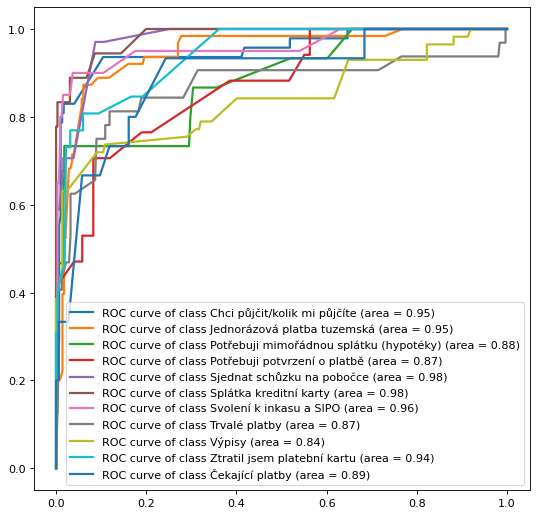

In [16]:
def show_loss_roc(labels, result_eval, train_y):
    loss = skm.log_loss(train_y, result_eval, labels=labels)
    roc = skm.roc_auc_score(train_y, result_eval, average='macro',
                        multi_class='ovo', labels=labels)
    print('loss', loss)
    print('roc', roc)
    train_y_bin = label_binarize(train_y, classes=labels)
    
    plt.figure(num=None, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(labels)):
        fpr[i], tpr[i], _ = skm.roc_curve(train_y_bin[:, i],
                                      np.array(result_eval)[:, i])
        roc_auc[i] = skm.auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], lw=2,
                 label=f'ROC curve of class {labels[i]} '
                       f'(area = {roc_auc[i]:.2f})')
    plt.legend()
    plt.show()

show_loss_roc(ensemble03.action_names, y_p_known03, y_t_known03)

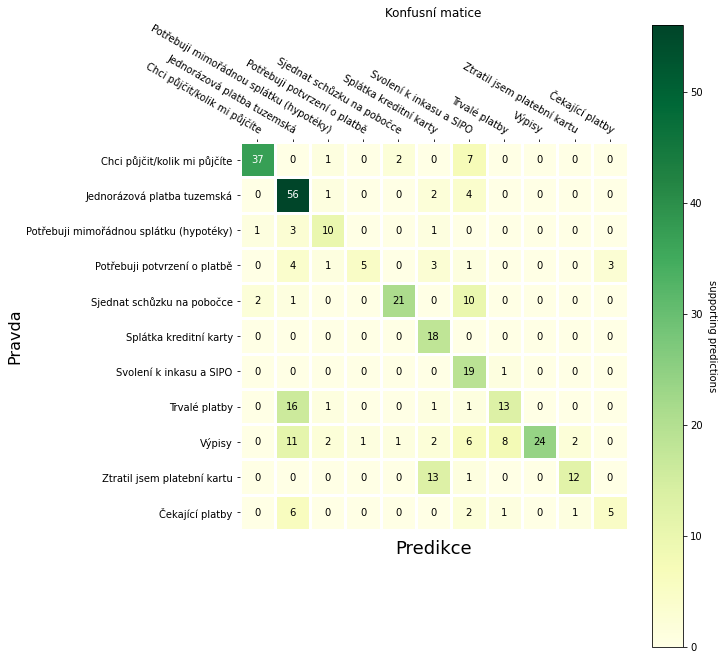

In [17]:
classes = np.unique(y_t_known03)
c_matrix = pd.DataFrame(index=classes, columns=classes).fillna(0)

for p, t in zip(y_p1_known03, y_t_known03):
    c_matrix[p].loc[t] += 1
# c_matrix

fig, ax = plt.subplots()
# plt.figure(figsize=(6,6))
fig.set_figheight(10)
fig.set_figwidth(10)

im, cbar = heatmap(c_matrix.values, c_matrix.index, c_matrix.columns, ax=ax,
                   cmap="YlGn", cbarlabel="supporting predictions")
texts = annotate_heatmap(im, valfmt="{x}")

fig.tight_layout()
plt.xlabel('Predikce', fontsize=18)
plt.ylabel('Pravda', fontsize=16)
plt.title('Konfusní matice')
plt.savefig(str(cur_dir / 'old_confusion.png'), dpi=500, bbox_inches='tight')
plt.show()

In [18]:
wrong03 = [{'dotaz': r['dotaz'], 
            'true': r['true'], 
            'pred3': r['pred3'],
            'prob3': r['prob3'],
           }  for r in results03 if r['true'] not in r['pred3'] and r['true'] != UNK]
df_wrong03 = pd.DataFrame(wrong03)
df_wrong03

dotaz  \
0                             dluh Martinovi za večeři   
1                           Internet 700 každý měsíc!    
2    Potřebuji zadat platbu, která bude splatná vžd...   
3                     Jaké platby mám zadané k úhradě?   
4                             Všechny platby proběhly?   
..                                                 ...   
96                          někdo mi ukradl kartu!!!!!   
97                                 ukradli mi kreditku   
98                                   zablokuj kreditku   
99                                  rezervované platby   
100                         výpis neprovedených plateb   

                            true  \
0    Jednorázová platba tuzemská   
1                  Trvalé platby   
2                  Trvalé platby   
3                Čekající platby   
4                Čekající platby   
..                           ...   
96   Ztratil jsem platební kartu   
97   Ztratil jsem platební kartu   
98   Ztratil jsem platební kartu   
99               Čekající platby   
100              Čekající platby   

                                                 pred3  \
0    [Potřebuji mimořádnou splátku (hypotéky), Splá...   
1    [Svolení k inkasu a SIPO, Jednorázová platba t...   
2    [Jednorázová platba tuzemská, Potřebuji mimořá...   
3    [Jednorázová platba tuzemská, Potřebuji potvrz...   
4    [Jednorázová platba tuzemská, Potřebuji potvrz...   
..                                                 ...   
96   [Splátka kreditní karty, Jednorázová platba tu...   
97   [Splátka kreditní karty, Svolení k inkasu a SI...   
98   [Splátka kreditní karty, Svolení k inkasu a SI...   
99   [Jednorázová platba tuzemská, Potřebuji potvrz...   
100  [Trvalé platby, Výpisy, Ztratil jsem platební ...   

                                                 prob3  
0    [0.17966781010259267, 0.17966781010259267, 0.0...  
1    [0.11987037598828476, 0.11582266865915364, 0.1...  
2    [0.1383490073145245, 0.13164402647161266, 0.13...  
3    [0.24300504084699578, 0.12320089962108367, 0.1...  
4    [0.14813922184017622, 0.14250315098671407, 0.1...  
..                                                 ...  
96   [0.23736896999353363, 0.12883697047454584, 0.1...  
97   [0.20925520862203006, 0.08627786234371289, 0.0...  
98   [0.20925520862203006, 0.08627786234371289, 0.0...  
99   [0.14813922184017622, 0.14250315098671407, 0.1...  
100  [0.15845549886707963, 0.15845549886707963, 0.1...  

[101 rows x 4 columns]

### explain

In [19]:
stop_words = helpers.read_stop_words(root_dir / 'resources' / 'stopwords.txt')
tokenizer = Tokenizer(stop_words=stop_words)

In [14]:
qe = ensemble03.evaluators[1]

query = 'kdy muzu prijit vykradnout banku? :)'
# query = 'zadat platbu 12000 na účet 167559324/0300 se zprávou "servis Peugeot“'
query = 'Toš, jak velký peníze si můžu půjčit?'
query = 'Internet 700 každý měsíc!'
query = 'seznam travlych prikazu'
query = 'Toš kolik jsem zaplatil za leden.'
query = 'Chci videt seznam čekajícich plateb.'
tokens = tokenizer.fit(query)
qe.explain(tokens)

({'Svolení k inkasu a SIPO': ['sipo'],
  'Trvalé platby': ['plateb'],
  'Ztratil jsem platební kartu': ['plateb', 'vydat']},
 [('videt', 'vydat'), ('plateb', 'plateb')])

## Stary model - vylepseny, po grid search
- model je stale predtrenovany, takze trenovacia mnozina je v tomto kontexte zas irelevantna.
- parametre najdene pomocou gridsearch, sledovana metrika bola log_loss
- vyhodil som z ensemble entity_recognizer na predikciu intentu, lebo bol slaby (analyticky zle vytvorena matica klucovych slov)

In [15]:
# pe = [5250]
# gb = [40]
# nc = [1]
# lm = [2]
# weights = [[0, 1], [1, 1]]

# results = []
# for p, g, n, l, w in product(pe, gb, nc, lm, weights):
#     nb_params = dict(
#         prior_denominator=p,
#         general_bf=g,
#         n_best_candidates=n,
#         largest_mistake=l,
#     )
#     recipe['nb_parameters'] = nb_params
#     recipe['weights'] = w
#     model = create_ensemble(recipe)
#     res_gs = prediction_results(model, queries, w)
    
#     y_t_known_gs, y_p1_known_gs, y_p_known_gs = known_results(res_gs, ['Limity', 'PIN', 'Jednorázová Platba Zahraniční', 'Sjednat Hypotéku'])
    
#     labels = model.action_names
#     loss = skm.log_loss(y_t_known_gs, y_p_known_gs, labels=labels)
#     roc = skm.roc_auc_score(y_t_known_gs, y_p_known_gs, average='macro',
#                         multi_class='ovo', labels=labels)
#     results.append(((loss, roc), recipe))
#     print('loss', loss)
#     print('roc', roc)
#     print((nb_params, w))
    
    

In [16]:
# sorted(results, key=lambda x: x[0][1], reverse=True)

In [14]:
p, g, n, l = 5250, 40, 1, 2
w = [.2, 1]
nb_params = dict(
    prior_denominator=p,
    general_bf=g,
    n_best_candidates=n,
    largest_mistake=l,
)
recipe['nb_parameters'] = nb_params
recipe['weights'] = w
ensemble031 = create_ensemble(recipe)
res031 = prediction_results(ensemble031, queries, w)

y_t_known031, y_p1_known031, y_p_known031 = known_results(res031, ['Limity', 'PIN', 'Jednorázová Platba Zahraniční', 'Sjednat Hypotéku'])

In [15]:
df_res031 = pd.DataFrame(res031)
top031 = df_res031.groupby('true').mean().join(
df_res031.groupby('true').count().rename(columns={'dotaz': 'support'}).drop(columns=['pred1', 'top1', 'top3', 'pred'])
)
top031

top1      top3  support  pred3  \
true                                                                          
0-UNKNOWN                                0.000000  0.000000       44     44   
Chci půjčit/kolik mi půjčíte             0.595745  0.787234       47     47   
Jednorázová platba tuzemská              0.888889  1.000000       63     63   
Limity                                   0.000000  0.000000       18     18   
Potřebuji mimořádnou splátku (hypotéky)  0.733333  0.733333       15     15   
Potřebuji potvrzení o platbě             0.294118  0.647059       17     17   
Sjednat Hypotéku                         0.000000  0.000000       14     14   
Sjednat schůzku na pobočce               0.588235  0.676471       34     34   
Splátka kreditní karty                   0.944444  1.000000       18     18   
Svolení k inkasu a SIPO                  0.950000  0.950000       20     20   
Trvalé platby                            0.375000  0.750000       32     32   
Výpisy                                   0.421053  0.543860       57     57   
Ztratil jsem platební kartu              0.423077  0.769231       26     26   
Čekající platby                          0.266667  0.266667       15     15   

                                         prob3  
true                                            
0-UNKNOWN                                   44  
Chci půjčit/kolik mi půjčíte                47  
Jednorázová platba tuzemská                 63  
Limity                                      18  
Potřebuji mimořádnou splátku (hypotéky)     15  
Potřebuji potvrzení o platbě                17  
Sjednat Hypotéku                            14  
Sjednat schůzku na pobočce                  34  
Splátka kreditní karty                      18  
Svolení k inkasu a SIPO                     20  
Trvalé platby                               32  
Výpisy                                      57  
Ztratil jsem platební kartu                 26  
Čekající platby                             15

loss 1.2962645999026996
roc 0.9156951335753829


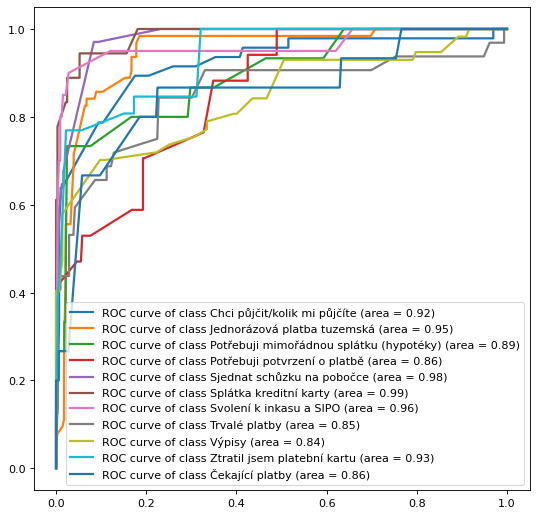

In [16]:
show_loss_roc(ensemble031.action_names, y_p_known031, y_t_known031)

# Novy model
- matica klucovych slov bola vytvorena analyticky zo vsetkych dotazov.
    - vybral som relevantne klucove slova a rozhodoval som sa na zaklade pocestnosti vyskytu slova pre jednotlive triedy.
- nepouzivam na klasifikaciu entity_recognizer
- query_evaluator som upravil tak, aby neriesil diakritiku a dal mu vahu 0.8 vo vysledku


In [32]:
currencies = helpers.read_currencies(root_dir / 'resources' / 'toy_currencies.csv')
# keyword_matrix = helpers.read_keyword_matrix(cur_dir / 'kw_matrix2-21-02-03.csv')
keyword_matrix = helpers.read_keyword_matrix(root_dir / 'resources' / 'kw_matrix04.csv')
stop_words = helpers.read_stop_words(root_dir / 'resources' / 'stopwords.txt')
tokenizer = Tokenizer(stop_words=stop_words)

# keyword_matrix_log = helpers.read_keyword_matrix(cur_dir / 'kw_matrix1-21-02-03.csv')
# keyword_matrix = np.log1p(keyword_matrix_log)

# entity_matrix = helpers.read_entity_matrix(cur_dir / 'ent_matrix04.csv')
entity_matrix = helpers.read_entity_matrix(root_dir / 'resources' / 'ent_matrix04.csv')

pe, gb, nc, lm = 5250, 40, 1, 2

q_evaluator = QueryEvaluator(keyword_matrix,
                             prior_denominator=pe, general_bf=gb,
                             n_best_candidates=nc, largest_mistake=lm)
e_evaluator = EntityRecognizer(entity_matrix, currencies,
                               prior_denominator=pe, general_bf=gb)

qa_evaluator = QueryEvaluatorNoAccents(keyword_matrix,
                             prior_denominator=pe, general_bf=gb,
                             n_best_candidates=nc, largest_mistake=lm)

ensemble04 = Ensemble(list(keyword_matrix.columns),
                    [q_evaluator, qa_evaluator, e_evaluator], tokenizer)

In [53]:
print(entity_matrix.columns)
print(keyword_matrix.columns)

Index(['Chci půjčit/kolik mi půjčíte', 'Jednorázová platba tuzemská', 'Limity',
       'Potřebuji mimořádnou splátku (hypotéky)',
       'Potřebuji potvrzení o platbě', 'Sjednat Hypotéku',
       'Sjednat schůzku na pobočce', 'Splátka kreditní karty',
       'Svolení k inkasu a SIPO', 'Trvalé platby', 'Výpisy',
       'Ztratil jsem platební kartu', 'Čekající platby'],
      dtype='object')
Index(['Chci půjčit/kolik mi půjčíte', 'Jednorázová platba tuzemská', 'Limity',
       'Potřebuji mimořádnou splátku (hypotéky)',
       'Potřebuji potvrzení o platbě', 'Sjednat Hypotéku',
       'Sjednat schůzku na pobočce', 'Splátka kreditní karty',
       'Svolení k inkasu a SIPO', 'Trvalé platby', 'Výpisy',
       'Ztratil jsem platební kartu', 'Čekající platby'],
      dtype='object')


In [70]:
results04 = prediction_results(ensemble04, queries, [10, 8, 0])
y_t_known04, y_p1_known04, y_p_known04 = known_results(results04, [UNK])

In [71]:
df_res04 = pd.DataFrame(results04)
top04 = df_res04.groupby('true').mean().join(
df_res04.groupby('true').count().rename(columns={'dotaz': 'support'}).drop(columns=['pred1', 'top1', 'top3', 'pred'])
)
top04

top1      top3  support  pred3  \
true                                                                          
0-UNKNOWN                                0.000000  0.000000       44     44   
Chci půjčit/kolik mi půjčíte             0.851064  1.000000       47     47   
Jednorázová platba tuzemská              0.968254  0.984127       63     63   
Limity                                   0.888889  1.000000       18     18   
Potřebuji mimořádnou splátku (hypotéky)  0.600000  0.933333       15     15   
Potřebuji potvrzení o platbě             0.764706  0.941176       17     17   
Sjednat Hypotéku                         0.785714  0.928571       14     14   
Sjednat schůzku na pobočce               0.852941  0.970588       34     34   
Splátka kreditní karty                   0.666667  1.000000       18     18   
Svolení k inkasu a SIPO                  0.900000  0.900000       20     20   
Trvalé platby                            0.750000  0.843750       32     32   
Výpisy                                   0.771930  0.894737       57     57   
Ztratil jsem platební kartu              0.884615  1.000000       26     26   
Čekající platby                          0.666667  0.733333       15     15   

                                         prob3  
true                                            
0-UNKNOWN                                   44  
Chci půjčit/kolik mi půjčíte                47  
Jednorázová platba tuzemská                 63  
Limity                                      18  
Potřebuji mimořádnou splátku (hypotéky)     15  
Potřebuji potvrzení o platbě                17  
Sjednat Hypotéku                            14  
Sjednat schůzku na pobočce                  34  
Splátka kreditní karty                      18  
Svolení k inkasu a SIPO                     20  
Trvalé platby                               32  
Výpisy                                      57  
Ztratil jsem platební kartu                 26  
Čekající platby                             15

In [72]:
print(skm.classification_report(y_t_known04, y_p1_known04))

                                         precision    recall  f1-score   support

           Chci půjčit/kolik mi půjčíte       0.87      0.85      0.86        47
            Jednorázová platba tuzemská       0.73      0.97      0.84        63
                                 Limity       0.94      0.89      0.91        18
Potřebuji mimořádnou splátku (hypotéky)       0.45      0.60      0.51        15
           Potřebuji potvrzení o platbě       1.00      0.76      0.87        17
                       Sjednat Hypotéku       0.39      0.79      0.52        14
             Sjednat schůzku na pobočce       0.97      0.85      0.91        34
                 Splátka kreditní karty       0.75      0.67      0.71        18
                Svolení k inkasu a SIPO       0.90      0.90      0.90        20
                          Trvalé platby       0.96      0.75      0.84        32
                                 Výpisy       0.98      0.77      0.86        57
            Ztratil jsem pl

In [73]:
print(f'MCC: {skm.matthews_corrcoef(y_t_known04, y_p1_known04)}')

MCC: 0.807340434233925


loss 0.6955398069529547
roc 0.9802379605135189


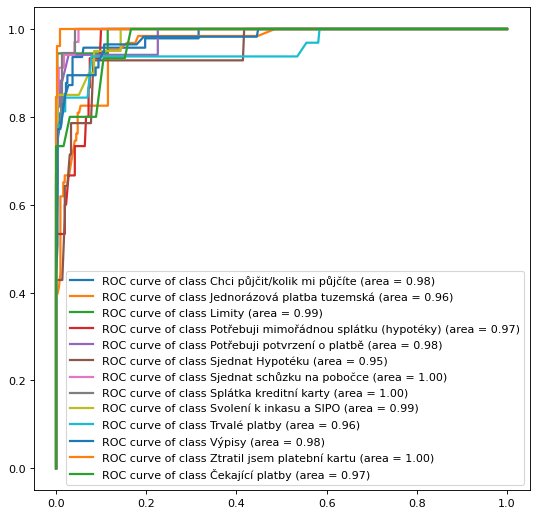

In [74]:
show_loss_roc(ensemble04.action_names, y_p_known04, y_t_known04)

In [38]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## Zle predikcie noveho modela
### confusion matrix

In [27]:
classes = np.unique(y_t_known04)
c_matrix = pd.DataFrame(index=classes, columns=classes).fillna(0)

for p, t in zip(y_p1_known04, y_t_known04):
    c_matrix[p].loc[t] += 1
# c_matrix    

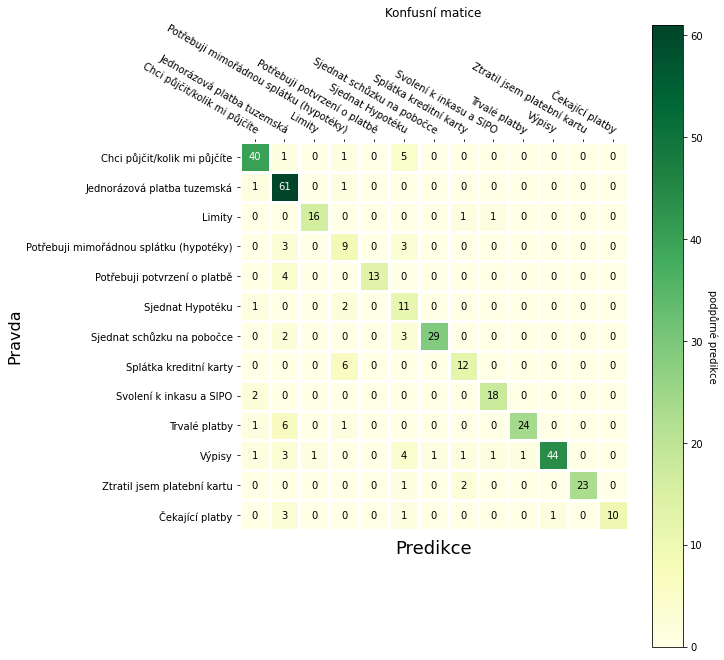

In [28]:
fig, ax = plt.subplots()
# plt.figure(figsize=(6,6))
fig.set_figheight(10)
fig.set_figwidth(10)

im, cbar = heatmap(c_matrix.values, c_matrix.index, c_matrix.columns, ax=ax,
                   cmap="YlGn", cbarlabel="podpůrné predikce")
texts = annotate_heatmap(im, valfmt="{x}")

fig.tight_layout()
plt.xlabel('Predikce', fontsize=18)
plt.ylabel('Pravda', fontsize=16)
plt.title('Konfusní matice')
plt.savefig(str(cur_dir / 'confusion04.png'), dpi=500, bbox_inches='tight')
plt.show()

### nenachadzajuce sa v top3

In [29]:
wrong04 = [{'dotaz': r['dotaz'], 
            'true': r['true'], 
            'pred3': r['pred3'],
            'prob3': r['prob3'],
           }  for r in results04 if r['true'] not in r['pred3'] and r['true'] != UNK]
df_wrong04 = pd.DataFrame(wrong04)
df_wrong04

dotaz  \
0                                                          dluh Martinovi za večeři   
1                                              Nastavit souhlas se strháváním peněz   
2                                              Zvyš na 2000 vodu, plyn a elektřinu.   
3                                           Měsíční platba za internet 800, prosím.   
4                                                         zrušit pravideůnou platbu   
5                                                          Všechny platby proběhly?   
6                                                            Za co jsem dnes platil   
7                                  kolik mám do konce měsíce naplánovaných výdavků?   
8   Mohu zaplatit výjimečně vyšší částku než mám sjednanou ve splátkovém kalendáři?   
9                                         Franta říká, že ty peníze ješte nedostal.   
10                                 Chci bydlet ve vlastním, ale nemám na to peníze.   
11                                                 Otvírací doba na Národní třídě?    
12                                             Platby nad 500,- v příštích 14 dnech   
13                                                     Kdy odejde splátka hypotéky?   
14                                              Počet zbývajících splátek hypotéky.   
15                                                     Kdy odešla splátka hypotéky?   
16                                                                        přeplatky   
17                                           jake platby jsem uskutecnila v breznu?   
18                                                      jaké jsou mé příjmy za rok?   
19                                                             kolik mám naspořeno?   
20                                                             přijaté platby leden   
21                                                       výpis neprovedených plateb   

                                       true  \
0               Jednorázová platba tuzemská   
1                   Svolení k inkasu a SIPO   
2                   Svolení k inkasu a SIPO   
3                             Trvalé platby   
4                             Trvalé platby   
5                           Čekající platby   
6                           Čekající platby   
7                           Čekající platby   
8   Potřebuji mimořádnou splátku (hypotéky)   
9              Potřebuji potvrzení o platbě   
10                         Sjednat Hypotéku   
11               Sjednat schůzku na pobočce   
12                            Trvalé platby   
13                            Trvalé platby   
14                            Trvalé platby   
15                                   Výpisy   
16                                   Výpisy   
17                                   Výpisy   
18                                   Výpisy   
19                                   Výpisy   
20                                   Výpisy   
21                          Čekající platby   

                                                                                                   pred3  \
0        [Potřebuji mimořádnou splátku (hypotéky), Splátka kreditní karty, Chci půjčit/kolik mi půjčíte]   
1   [Chci půjčit/kolik mi půjčíte, Jednorázová platba tuzemská, Potřebuji mimořádnou splátku (hypotéky)]   
2                               [Chci půjčit/kolik mi půjčíte, Sjednat Hypotéku, Splátka kreditní karty]   
3                                    [Jednorázová platba tuzemská, Limity, Potřebuji potvrzení o platbě]   
4                                    [Jednorázová platba tuzemská, Limity, Potřebuji potvrzení o platbě]   
5                                    [Jednorázová platba tuzemská, Limity, Potřebuji potvrzení o platbě]   
6                                    [Jednorázová platba tuzemská, Limity, Potřebuji potvrzení o platbě]   
7                          [Sjednat Hypotéku, Chci půjčit/kolik mi půjčíte, Jednorázová platba tuzemská]   
8                     

### nenachadzajuce sa v top1

In [30]:
wrong1_04 = [{'dotaz': r['dotaz'], 'true': r['true'], 'pred1': r['pred1']}  for r in results04 if r['true'] != r['pred1'] and r['true'] != UNK ]
df_wrong1_04 = pd.DataFrame(wrong1_04)
df_wrong1_04

dotaz  \
0                                                                 Kolik si mohu pujcit na dům?   
1                                           da se vypocitat kolik teoreticky bych dostal uver?   
2                                                        Prosím, 200 za oběd Petrovi Novákovi.   
3                                                                     dluh Martinovi za večeři   
4                                   mám nějaké peníze nazvyš, mohu je dát do splátky hypotéky?   
5                                        vím, že není termín pro splátku ale mám peníze nazvyš   
6                                                        Chci potvrzení, že jsem poslal peníze   
7                                                     chci potvrzení o platbě ze dne 20.1.2021   
8                                                                    Chci se potkat na pobočce   
9                                                            Potřeboval bych sjednat hypotéku.   
10                                                                dá se objednat termín u vás?   
11                                                                           Zaplatit kreditku   
12                                                                  potrebuju navysit kreditku   
13                                                             proveď splátku kreditky 4000 Kč   
14                                                                   splátka kreditky 5000 czk   
15                                                                      splátka úvěru kreditky   
16                                                                           zaplatit kreditku   
17                                                        Nastavit souhlas se strháváním peněz   
18                                                        Zvyš na 2000 vodu, plyn a elektřinu.   
19                                                     Měsíční platba 15000 na účet 01245/0800   
20                                                     Měsíční platba za internet 800, prosím.   
21    Potřebuji zadat platbu, která bude splatná vždy do 15. dne v měsíci po dobu jednoho roku   
22                                                                   zrušit pravideůnou platbu   
23                                                                          Kolik mám na účtě?   
24                                                                     jaký je zůstatek na BÚ?   
25                                                                  Asi mi bila odcizena karta   
26                                                                              Kde mám kartu?   
27                                                                   co kdyz nevim najit kartu   
28                                                            Jaké platby mám zadané k úhradě?   
29                                                                    Všechny platby proběhly?   
30                                                                      Za co jsem dnes platil   
31                                            kolik mám do konce měsíce naplánovaných výdavků?   
32                                                                  Chtěl bych půjčit 50000 kč   
33                                                                    Chtěl bych si vzít úvěr.   
34  Kdybych si chtěl koupit auto, jak jsem býval chtěl před rokem. Na kolik mě můžete založit?   
35                                                         Maximální úvěr s splátkou do 3500,-   
36                                                                dá se zde půjčit 5000 korun?   
37                                             kolik mám maximálně povolený výběr z bankomatu?   
38                                                  pro tenhle měsíc chci vyšší limit na kartě   
39                                                    Mám peníze navíc, co s nimi můžu udělat?   
40                                                                   De

### explain

In [79]:
query = 'Chci hypoteku.'
tokens = tokenizer.fit(query)
print(f'query: {query}')
print(q_evaluator.explain(tokens), end='\n\n')

query: Chci hypoteku.
({'Potřebuji mimořádnou splátku (hypotéky)': ['hypotéku'], 'Sjednat Hypotéku': ['hypotéku'], 'Sjednat schůzku na pobočce': ['hypotéku']}, [('hypoteku', 'hypotéku')])



In [31]:
query = 'Franta říká, že ty peníze ješte nedostal.'

for i, r in df_wrong04.sort_values('true').iterrows():
    query = r['dotaz']
    tokens = tokenizer.fit(query)
    print(f'query: {query} ; true: {r["true"]}')
    print(q_evaluator.explain(tokens), end='\n\n')

query: dluh Martinovi za večeři ; true: Jednorázová platba tuzemská
({'Potřebuji mimořádnou splátku (hypotéky)': ['dluh'], 'Splátka kreditní karty': ['dluh']}, [('dluh', 'dluh')])

query: Mohu zaplatit výjimečně vyšší částku než mám sjednanou ve splátkovém kalendáři? ; true: Potřebuji mimořádnou splátku (hypotéky)
({'Jednorázová platba tuzemská': ['zaplatit'], 'Potřebuji mimořádnou splátku (hypotéky)': ['zaplatit'], 'Sjednat Hypotéku': ['dům'], 'Splátka kreditní karty': ['zaplatit'], 'Svolení k inkasu a SIPO': ['zaplatit'], 'Trvalé platby': ['zaplatit']}, [('zaplatit', 'zaplatit'), ('mám', 'dům')])

query: Franta říká, že ty peníze ješte nedostal. ; true: Potřebuji potvrzení o platbě
({'Chci půjčit/kolik mi půjčíte': ['peníze'], 'Jednorázová platba tuzemská': ['dle', 'peníze'], 'Potřebuji mimořádnou splátku (hypotéky)': ['peníze'], 'Potřebuji potvrzení o platbě': ['peníze'], 'Čekající platby': ['front']}, [('franta', 'front'), ('že', 'dle'), ('peníze', 'peníze')])

query: Chci bydlet v

## nezname triedy dotazov

In [ ]:
df_res04[df_res04['true'] == UNK][['dotaz', 'pred1']]

# Napady

- velky korpus, povedzme od roznych projektov v profinite, ktore sa zaoberaju nejakym textom
- viac zaznamov a typov dotazov
    - vytvorit sam
    - mozem poziadat kamosov?
- vytazovnanie casu - mesiace, datumy (urcilo by to napr. vypisy, trvale platby)
- ak by bolo dost dotazov, pouzit transformer
- automatizovat NB (problematicke a zdlhave, ak by som chcel mat k dispozicii levenshteina)
- dorobit poriadne vytazovanie entit

# Zhrnutie

- novy model lepsi (ale overfitnuty) vdaka novym slovam
- preciznost je stale nizka
- komplikovanejsie (abstraktnejsie) dotazy nie su dobre klasifikovatelne
- mnoho stylov ako zapisat cislo - sumu
- tomasovi karellovi vdaka za perfektne matuce dotazy
- chyba tomu robustnost a smrnc

# sklearn pristup

In [104]:
import sklearn.model_selection as model_sel
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import GaussianNB
import sklearn.metrics as metr

In [105]:

X_train, X_test, y_train, y_test = model_sel.train_test_split(q_known['dotaz'], q_known['class'], test_size=0.25, random_state=42, stratify=q_known['class'])

In [106]:
np.unique(y_train, return_counts=True)

(array(['Chci půjčit/kolik mi půjčíte', 'Jednorázová platba tuzemská',
        'Limity', 'Potřebuji mimořádnou splátku (hypotéky)',
        'Potřebuji potvrzení o platbě', 'Sjednat Hypotéku',
        'Sjednat schůzku na pobočce', 'Splátka kreditní karty',
        'Svolení k inkasu a SIPO', 'Trvalé platby', 'Výpisy',
        'Ztratil jsem platební kartu', 'Čekající platby'], dtype=object),
 array([35, 47, 13, 11, 13, 11, 26, 13, 15, 24, 43, 20, 11], dtype=int64))

In [107]:
np.unique(y_test, return_counts=True)

(array(['Chci půjčit/kolik mi půjčíte', 'Jednorázová platba tuzemská',
        'Limity', 'Potřebuji mimořádnou splátku (hypotéky)',
        'Potřebuji potvrzení o platbě', 'Sjednat Hypotéku',
        'Sjednat schůzku na pobočce', 'Splátka kreditní karty',
        'Svolení k inkasu a SIPO', 'Trvalé platby', 'Výpisy',
        'Ztratil jsem platební kartu', 'Čekající platby'], dtype=object),
 array([12, 16,  5,  4,  4,  3,  8,  5,  5,  8, 14,  6,  4], dtype=int64))

In [118]:
words = []
for x, y in zip(X_train, y_train):
#     print(q)
    tokens = tokenizer.fit(x)
    tokens = e_evaluator.fit(tokens)
    query_simple = ''
    for t in tokens:
        to_append = None
        if t[1] == 'KW':
            to_append = t[0]
        elif t[1] == 'AMT':
            to_append = ':AMT:'
        elif t[1] == 'IBAN':
            to_append = ':IBAN:'
        elif t[1] == 'ACC':
            to_append = ':ACC:'
        if to_append:
            query_simple += to_append + ' '
    words.append({'words': query_simple, 'class': y})
train_df = pd.DataFrame(words)
X, y = train_df['words'], train_df['class']
X

0                   dělat když ukradli kartu 
1                             potkat pobočce 
2      zadat trvalou platbu :AMT: účet :ACC: 
3                          zaplatit kreditku 
4                           zobrazit výplatu 
                        ...                  
277                   kdyz nevim najit kartu 
278                   splátka kreditky :AMT: 
279                        zablokuj kreditku 
280              nastavit opakujujici platbu 
281                     proběhla platba alzy 
Name: words, Length: 282, dtype: object

In [142]:
cnt_vect = CountVectorizer(analyzer='char_wb', ngram_range=(5, 7))
counts = cnt_vect.fit_transform(np.array(X))
print(cnt_vect.get_feature_names())
X_ngram = counts.toarray().astype(int)
counts.shape

[' :acc', ' :acc:', ' :acc: ', ' :amt', ' :amt:', ' :amt: ', ' alzy', ' alzy ', ' auto', ' auto ', ' autom', ' automa', ' banc', ' bance', ' bance ', ' bank', ' banka', ' bankam', ' banko', ' bankom', ' bankov', ' banké', ' bankéř', ' bila', ' bila ', ' brez', ' brezn', ' breznu', ' by ', ' bych', ' bych ', ' bydl', ' bydle', ' bydlet', ' bydli', ' bydliš', ' byt ', ' bytě', ' bytě ', ' bú ', ' býva', ' býval', ' býval ', ' běžn', ' běžné', ' běžné ', ' běžnéh', ' chte', ' chtel', ' chtel ', ' chtě', ' chtěl', ' chtěl ', ' chtěla', ' dceř', ' dceře', ' dceře ', ' dej ', ' dela', ' delat', ' delat ', ' dluh', ' dluh ', ' dluhu', ' dluhu ', ' dne ', ' dnec', ' dnech', ' dnech ', ' dobu', ' dobu ', ' dokl', ' dokla', ' doklad', ' doml', ' domlu', ' domluv', ' domá', ' domác', ' domácí', ' dost', ' dosta', ' dostan', ' dostat', ' dota', ' dotaz', ' dotaz ', ' doča', ' dočas', ' dočasn', ' dá ', ' dát ', ' děla', ' dělat', ' dělat ', ' dům ', ' elek', ' elekt', ' elektř', ' fakt', ' faktu',

(282, 3975)

In [143]:
scorer = metr.make_scorer(metr.top_k_accuracy_score, k=3)
scorer = metr.make_scorer(metr.roc_auc_score)

In [144]:
cv_results = model_sel.cross_validate(GaussianNB(), X_ngram, y, 
                         scoring='roc_auc_ovo', cv=model_sel.StratifiedKFold(3), n_jobs=-1, return_train_score=True, return_estimator=True)

In [145]:
cv_results

{'fit_time': array([0.05200195, 0.059026  , 0.05300426]),
 'score_time': array([0.2679975 , 0.2739737 , 0.26999664]),
 'estimator': [GaussianNB(), GaussianNB(), GaussianNB()],
 'test_score': array([0.89148452, 0.83602073, 0.8177656 ]),
 'train_score': array([0.99204864, 0.99415615, 0.99826389])}

In [141]:
# keyword_matrix.drop(columns=['Jednorázová Platba Zahraniční', 'PIN']).reset_index().to_csv(cur_dir / 'kw_matrix2-21-02-03.csv', index=False)

# entity matrix vytvorenie

In [88]:
entities_path = cur_dir / 'query_entities-2021-02-03.json'
import json
with open(entities_path, 'r', encoding='utf8') as f:
    j = json.load(f)
ent_data = pd.DataFrame(j)
ent_data

query  \
0    Kdybych si chtěl koupit auto, jaká by byla možná výše půjčky?   
1                                     Kolik si mohu pujcit na dům?   
2                                            Kolik si mohu půjčit?   
3                                    Kolik si mohu zažádat na úvěr   
4                                      Potřebuji půjčit do výplaty   
..                                                             ...   
364                                              zablokuj kreditku   
365                                             zreatil jsem kartu   
366                           Chci videt seznam čekajícich plateb.   
367                                             rezervované platby   
368                                     výpis neprovedených plateb   

                           intent entities  \
0    Chci půjčit/kolik mi půjčíte       {}   
1    Chci půjčit/kolik mi půjčíte       {}   
2    Chci půjčit/kolik mi půjčíte       {}   
3    Chci půjčit/kolik mi půjčíte       {}   
4    Chci půjčit/kolik mi půjčíte       {}   
..                            ...      ...   
364   Ztratil jsem platební kartu       {}   
365   Ztratil jsem platební kartu       {}   
366               Čekající platby       {}   
367               Čekající platby       {}   
368               Čekající platby       {}   

                                                                                                                                                            tokens  
0    [[kdybych, KW], [si, SW], [chtěl, KW], [koupit, KW], [auto, KW], [,, NKW], [jaká, KW], [by, KW], [byla, SW], [možná, KW], [výše, KW], [půjčky, KW], [?, NKW]]  
1                                                                                 [[kolik, SW], [si, SW], [mohu, KW], [pujcit, KW], [na, SW], [dům, KW], [?, NKW]]  
2                                                                                                      [[kolik, SW], [si, SW], [mohu, KW], [půjčit, KW], [?, NKW]]  
3                                                                                         [[kolik, SW], [si, SW], [mohu, KW], [zažádat, KW], [na, SW], [úvěr, KW]]  
4                                                                                                         [[potřebuji, KW], [půjčit, KW], [do, SW], [výplaty, KW]]  
..                                                                                                                                                             ...  
364                                                                                                                               [[zablokuj, KW], [kreditku, KW]]  
365                                                                                                                       [[zreatil, KW], [jsem, SW], [kartu, KW]]  
366                                                                              [[chci, SW], [videt, KW], [seznam, KW], [čekajícich, KW], [plateb, KW], [., NKW]]  
367                                                                                                                              [[rezervované, KW], [platby, KW]]  
368                                                                                                               [[výpis, KW], [neprovedených, KW], [plateb, KW]]  

[369 rows x 4 columns]

In [102]:
ent_data[ent_data['entities'] != {} & ent_data['intent'] == 'V']

query  \
5                                                               Půjčka 1200 000 Kč na auto   
6                                                                  Půjčka 1200 000 na auto   
22                                                Chci poslat 299€ na účet 9876543210/1234   
24                                                       Platba 150 kč na účet 117242/0300   
25                                                                   Poslat 1500 na spořák   
26                                                              Poslat 200 Kč přes QR kód.   
28                                                           Pošli 10 000 na spořící účet.   
29                                                                      Pošli 100 Kč mámě!   
30                                                                  Pošli 1234,- Veronice.   
31                                                    Pošli 158 korun na 12-456456456/8080   
32                                                   Prosím, 200 za oběd Petrovi Novákovi.   
33                                                          Přesuň 10 000 na spořící účet.   
34                                                             Převeď 10k na spořící účet.   
35                                                       Převeď 1584 korun na spořící účet   
36                                        Převeď z běžného účtu 1584 korun na spořící účet   
37                                                                Převod 5000 na účet 1234   
38                                                      Toš zaplať 100 za večeři bratrovi.   
39                                                                      Zaplait 500 matce.   
40                                                               Zaplatit 20000 Petr Novák   
41                                                                  Zaplatit 500 kč matce.   
42                                                                     Zaplatit 500 matce.   
51                                                                           poslat 100 kč   
52                                                                   poslat 20 korun matce   
53                                                     poslat 20 korun na muj sporici ucet   
54                                                 poslat 200 korun matce na 12345678/2010   
55                                                                        poslat 200 matce   
56                                                                             poslat 2000   
57                                                                        poslat 300 matce   
58                                                                        poslat 500 matce   
59                                                                       poslat 500 matce.   
64                                                        pošli 300 na účet 154232323/0800   
65                                                                       pošli 375 na účet   
69                  zadat platbu 100 kč na účet 167559324/0300 se zprávou "Splátka půjčky"   
70                   zadat platbu 12000 na účet 167559324/0300 se zprávou "servis Peugeot"   
74                                                                 zaplatit ségře 30 korun   
76                                                                      zaptatit 1250 plyn   
77                                                   zaslat 500 korun na ucet 12e123/132e3   
126                                                        proveď splátku kreditky 4000 Kč   
130                                                              splátka kreditky 5000 czk   
137                                  Povolit měsiční INKASO na účet 117292/0300 častka 400   
140                                                   Zvyš na 2000 vodu, plyn a elektřinu.   
154                                Chci zadat trvalou platbu 15kč na účet 9999999999/1234.   
156                                        

In [103]:
res = []
for i, row in ent_data[ent_data.entities != {}].iterrows():
    for k, v in row['entities'].items():
        res.append({'class': row['intent'], 'entity': k})

df = pd.DataFrame(res)

pd.concat([df.drop(columns=['class']), pd.get_dummies(df['class'])], axis=1).groupby('entity').sum().to_csv(cur_dir / 'ent_matrix-21-02-03-count.csv')